In [214]:
import pandas as pd
import warnings
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from pmdarima import auto_arima

In [77]:
df = pd.read_csv("churn_clean.csv")
df.head()

,Day,Revenue
0,1,0.000000
1,2,0.000793
2,3,0.825542
3,4,0.320332
4,5,1.082554


In [79]:
#Switching day to datetime)
start_date = datetime(2024, 1, 1)
df['Date']= df['Day'].apply(lambda x: start_date + timedelta(days=x))
df = df.set_index('Date')
df= df.drop('Day', axis=1)
df.sort_index()

,Revenue
Date,
2024-01-02,0.000000
2024-01-03,0.000793
2024-01-04,0.825542
2024-01-05,0.320332
2024-01-06,1.082554
...,...
2025-12-28,16.931559
2025-12-29,17.490666
2025-12-30,16.803638


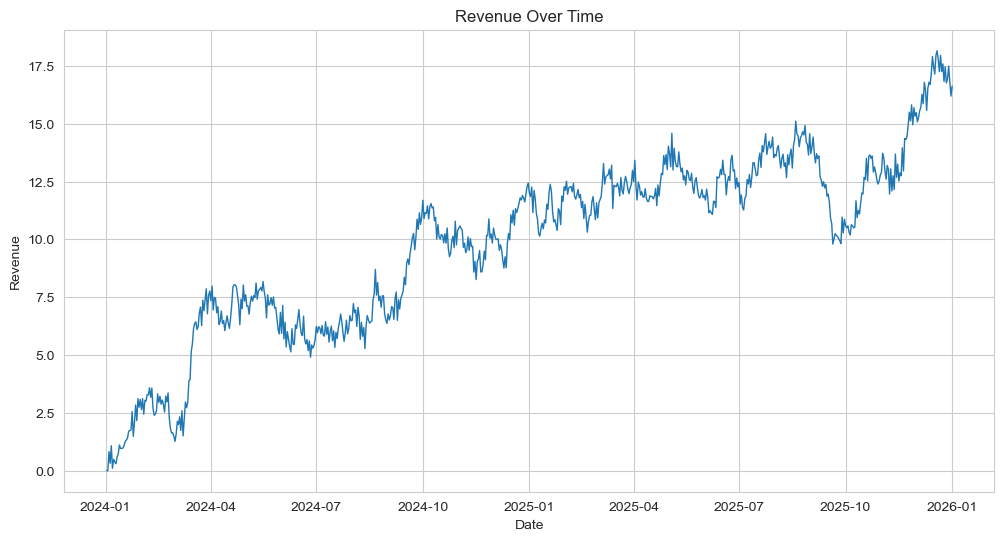

In [81]:
plt.figure(figsize=(12, 6))  # Set figure size

sns.lineplot(data=df, x='Date', y='Revenue', linewidth=1)

# Customize the plot
plt.title('Revenue Over Time')
plt.xlabel('Date')
plt.ylabel('Revenue')


# Show the plot
plt.show()

In [90]:
#checking time step
time_diffs = df.index.to_series().diff()
unique_diffs = time_diffs.unique()
unique_diffs = unique_diffs[~pd.isna(unique_diffs)]

print(unique_diffs)

# Check if time steps are consistent
if len(unique_diffs) == 1:
    print(f"Time steps are consistent: {unique_diffs[0]}")
else:
    print("Warning: Inconsistent time steps detected")

<TimedeltaArray>
['1 days']
Length: 1, dtype: timedelta64[ns]
Time steps are consistent: 1 days 00:00:00


In [92]:
print("Min date:", df.index.min())
print("Max date:", df.index.max())
print("Total days:", (df.index.max() - df.index.min()).days)

Min date: 2024-01-02 00:00:00
Max date: 2026-01-01 00:00:00
Total days: 730


In [102]:
acf_array = acf(df, alpha=0.9)
print(acf_array)

(array([1.        , 0.98375067, 0.97679376, 0.96584953, 0.95545834,
       0.94515237, 0.93469998, 0.92356074, 0.91259674, 0.9007179 ,
       0.88986482, 0.87820542, 0.86783127, 0.85669648, 0.84568014,
       0.83433728, 0.82369773, 0.81266219, 0.80261913, 0.79240124,
       0.78364098, 0.77521764, 0.76563762, 0.75985141, 0.75066964,
       0.742678  , 0.73537013, 0.72746968, 0.72092685]), array([[1.        , 1.        ],
       [0.97910291, 0.98839842],
       [0.96883058, 0.98475693],
       [0.95562048, 0.97607858],
       [0.94341939, 0.96749729],
       [0.93157384, 0.9587309 ],
       [0.91976778, 0.94963217],
       [0.90741405, 0.93970743],
       [0.89534662, 0.92984685],
       [0.88245462, 0.91898118],
       [0.87066591, 0.90906372],
       [0.85813532, 0.89827552],
       [0.84694757, 0.88871497],
       [0.83504777, 0.87834519],
       [0.82331108, 0.8680492 ],
       [0.81128792, 0.85738663],
       [0.80000496, 0.8473905 ],
       [0.7883587 , 0.83696568],
       [0.777

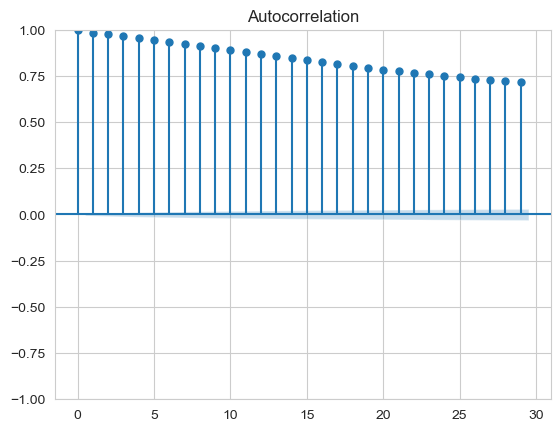

In [100]:
plot_acf(df, alpha=0.9)
plt.show()

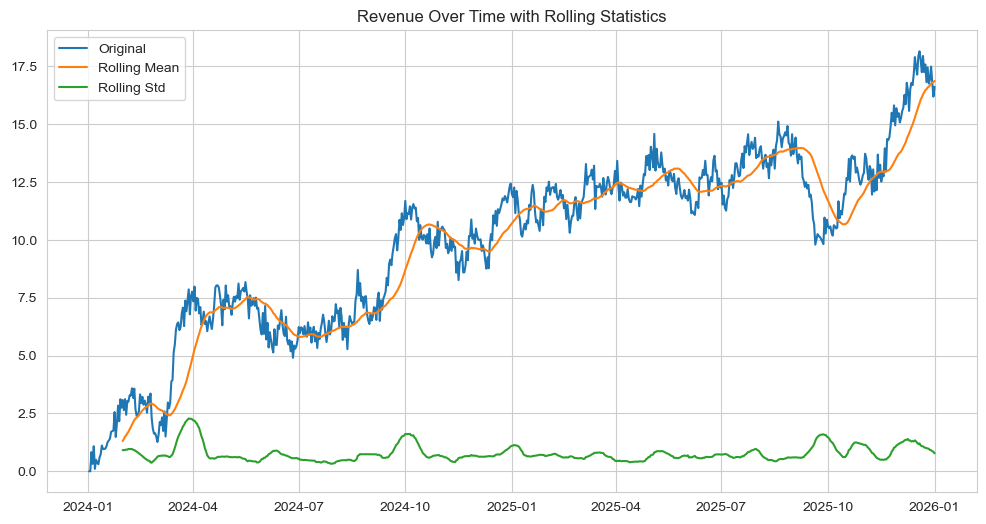

In [112]:
rolling_mean = df['Revenue'].rolling(window=30).mean()
rolling_std = df['Revenue'].rolling(window=30).std()

# Plotting with date index
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label='Original')
plt.plot(df.index, rolling_mean, label='Rolling Mean')
plt.plot(df.index, rolling_std, label='Rolling Std')
plt.title('Revenue Over Time with Rolling Statistics')
plt.legend()


C:\Users\1isad\anaconda3\Lib\site-packages\pandas\core\arraylike.py:399: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


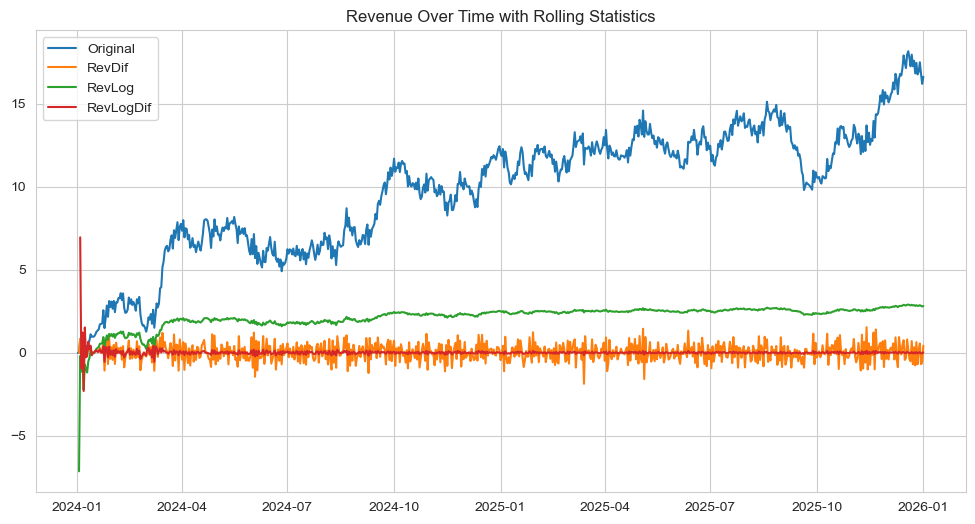

In [126]:
#Possible Transformations
df['revenue_diff'] = df['Revenue'].diff()
df['revenue_log'] = np.log(df['Revenue'])
df['revenue_log_diff'] = df['revenue_log'].diff()

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Revenue'], label='Original')
plt.plot(df.index, df['revenue_diff'], label='RevDif')
plt.plot(df.index, df['revenue_log'], label='RevLog')
plt.plot(df.index, df['revenue_log_diff'], label='RevLogDif')
plt.title('Revenue Over Time with Rolling Statistics')
plt.legend()

In [134]:
def check_stationarity(timeseries):
    result = adfuller(timeseries.dropna()) 
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')

check_stationarity(df['revenue_diff'])

ADF Statistic: -44.87452719387599
p-value: 0.0
Critical values:
	1%: -3.4393520240470554
	5%: -2.8655128165959236
	10%: -2.5688855736949163


In [142]:
df= df[['Revenue', 'revenue_diff']]
train_size = int(len(df) * 0.75)
train = df[:train_size]
test = df[train_size:]

df.to_csv('cleaneddata.csv', index=False)
train.to_csv('train.csv', index=False)
test.to_csv('test.csv', index=False)

Text(0.5, 1.0, 'Partial Autocorrelation Function')

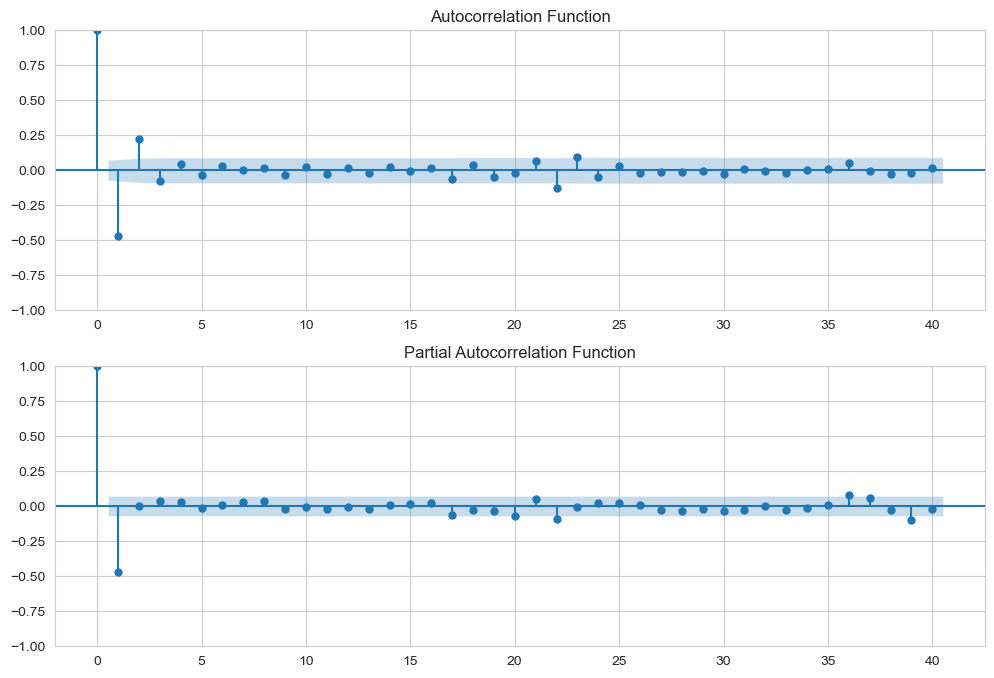

In [146]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))


plot_acf(df['revenue_diff'].dropna(), lags=40, ax=ax1)
ax1.set_title('Autocorrelation Function')

plot_pacf(df['revenue_diff'].dropna(), lags=40, ax=ax2)
ax2.set_title('Partial Autocorrelation Function')

In [210]:
#functions
def analyze_time_series(train):
    plt.style.use('classic')
    
    # Create visualization subplots
    fig, axes = plt.subplots(3, 2, figsize=(15, 15))
    
    # Original Time Series Plot
    axes[0,0].plot(train.index, train['Revenue'], color='blue')
    axes[0,0].set_title('Original Time Series', fontsize=12)
    axes[0,0].set_xlabel('Date', fontsize=10)
    axes[0,0].set_ylabel('Revenue', fontsize=10)
    axes[0,0].grid(True)
    
    # Decomposition with adjusted period
    decomposition = seasonal_decompose(train['Revenue'], period=30)
    
    # Plot components
    axes[0,1].plot(train.index, decomposition.trend, color='green')
    axes[0,1].set_title('Trend Component', fontsize=12)
    axes[0,1].set_xlabel('Date', fontsize=10)
    axes[0,1].grid(True)
    
    axes[1,0].plot(train.index, decomposition.seasonal, color='red')
    axes[1,0].set_title('Seasonal Component', fontsize=12)
    axes[1,0].set_xlabel('Date', fontsize=10)
    axes[1,0].grid(True)
    
    axes[1,1].plot(train.index, decomposition.resid, color='purple')
    axes[1,1].set_title('Residual Component', fontsize=12)
    axes[1,1].set_xlabel('Date', fontsize=10)
    axes[1,1].grid(True)
    
    # ACF Plot
    plot_acf(train['Revenue'], lags=40, ax=axes[2,0])
    axes[2,0].set_title('Autocorrelation Function', fontsize=12)
    axes[2,0].grid(True)
    
    # Spectral Density
    f, Pxx = signal.periodogram(train['Revenue'].dropna())
    axes[2,1].plot(f, Pxx, color='orange')
    axes[2,1].set_title('Spectral Density', fontsize=12)
    axes[2,1].set_xlabel('Frequency', fontsize=10)
    axes[2,1].set_ylabel('Power', fontsize=10)
    axes[2,1].grid(True)
    
    plt.tight_layout()
    
    # Test stationarity of residuals
    resid_results = adfuller(decomposition.resid.dropna())
    
    return decomposition, resid_results

def find_best_arima_params(train):
    # Use auto_arima to find optimal parameters
    model = auto_arima(train['Revenue'],
                      start_p=1, start_q=1,
                      max_p=5, max_q=5,
                      m=30, 
                      start_P=0, start_Q=0,
                      max_P=2, max_Q=2,
                      seasonal=True,
                      d=1, D=1,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)
    
    return model.order, model.seasonal_order

def fit_arima(train, order, seasonal_order=None):
    # Fit ARIMA model
    if seasonal_order:
        model = ARIMA(train['Revenue'], 
                     order=order,
                     seasonal_order=seasonal_order)
    else:
        model = ARIMA(train['Revenue'], order=order)
    
    results = model.fit()
    
    # Generate forecast with confidence intervals
    forecast = results.forecast(steps=30, alpha=0.05)
    
    # Plot results with confidence intervals
    plt.figure(figsize=(12, 6))
    plt.plot(train.index, train['Revenue'], label='Original', color='blue')
    
    # Create forecast index
    forecast_index = pd.date_range(start=train.index[-1], periods=31, freq='D')[1:]
    
    if isinstance(forecast, pd.Series):
        plt.plot(forecast_index, forecast, label='Forecast', color='red')
    else:
        # If forecast returns confidence intervals
        plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')
        plt.fill_between(forecast_index,
                        forecast.conf_int()[:,0],
                        forecast.conf_int()[:,1],
                        color='red', alpha=0.1)
    
    plt.title('ARIMA Forecast', fontsize=12)
    plt.xlabel('Date', fontsize=10)
    plt.ylabel('Revenue', fontsize=10)
    plt.legend()
    plt.grid(True)
    
    return results, forecast

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,0)[30]             : AIC=1075.210, Time=0.51 sec
 ARIMA(0,1,0)(0,1,0)[30]             : AIC=1197.916, Time=0.24 sec
 ARIMA(1,1,0)(1,1,0)[30]             : AIC=928.068, Time=1.18 sec
 ARIMA(0,1,1)(0,1,1)[30]             : AIC=inf, Time=8.16 sec
 ARIMA(1,1,0)(0,1,0)[30]             : AIC=1073.277, Time=0.19 sec
 ARIMA(1,1,0)(2,1,0)[30]             : AIC=848.444, Time=3.38 sec
 ARIMA(1,1,0)(2,1,1)[30]             : AIC=inf, Time=16.32 sec
 ARIMA(1,1,0)(1,1,1)[30]             : AIC=inf, Time=9.33 sec
 ARIMA(0,1,0)(2,1,0)[30]             : AIC=996.565, Time=2.34 sec
 ARIMA(2,1,0)(2,1,0)[30]             : AIC=850.292, Time=4.55 sec
 ARIMA(1,1,1)(2,1,0)[30]             : AIC=850.332, Time=5.21 sec
 ARIMA(0,1,1)(2,1,0)[30]             : AIC=881.765, Time=4.16 sec
 ARIMA(2,1,1)(2,1,0)[30]             : AIC=851.396, Time=12.63 sec
 ARIMA(1,1,0)(2,1,0)[30] intercept   : AIC=849.989, Time=9.02 sec

Best model:  ARIMA(1,1,0)(2,1,0)[30]   

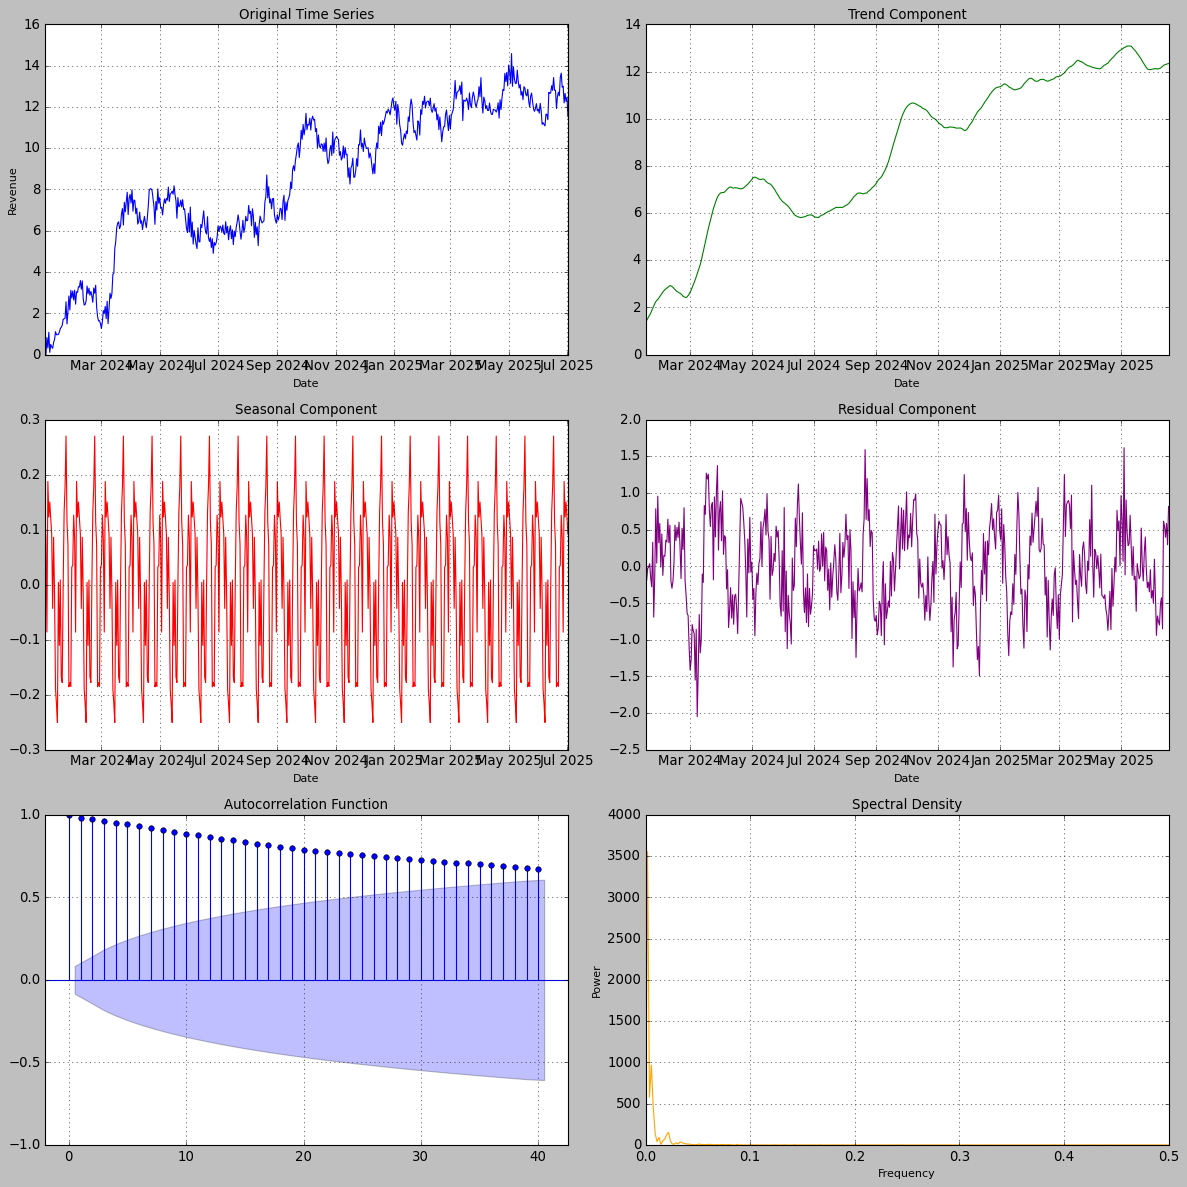

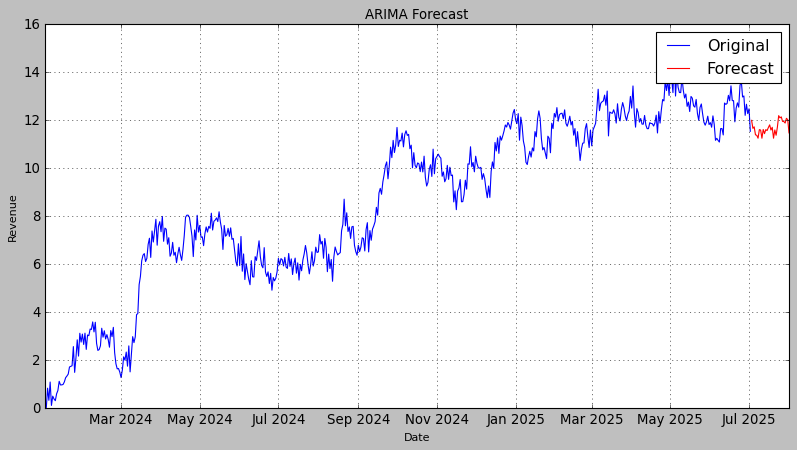

In [206]:
# Run the analysis
decomp, resid_test = analyze_time_series(train)

# Find optimal parameters using auto_arima
order, seasonal_order = find_best_arima_params(train)

# Fit final model and forecast
final_model, forecast = fit_arima(train, order=order, seasonal_order=seasonal_order)


In [208]:
# Print summary statistics
print(f"Best ARIMA Order (p,d,q): {order}")
print(f"Seasonal Order (P,D,Q,s): {seasonal_order}")
print("\nADF Test for Residuals:")
print(f"ADF Statistic: {resid_test[0]}")
print(f"p-value: {resid_test[1]}")
print("\nModel Summary:")
print(final_model.summary())

Best ARIMA Order (p,d,q): (1, 1, 0)
Seasonal Order (P,D,Q,s): (2, 1, 0, 30)

ADF Test for Residuals:
ADF Statistic: -8.167437605448272
p-value: 8.805574105177411e-13

Model Summary:
                                    SARIMAX Results                                     
Dep. Variable:                          Revenue   No. Observations:                  548
Model:             ARIMA(1, 1, 0)x(2, 1, 0, 30)   Log Likelihood                -420.222
Date:                          Wed, 12 Feb 2025   AIC                            848.444
Time:                                  21:46:31   BIC                            865.436
Sample:                              01-02-2024   HQIC                           855.102
                                   - 07-02-2025                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
---------------------------


Model Performance Metrics:
RMSE: 3.56
MAPE: 19.37%

First few predictions vs actuals:
               Actual  Predicted
Date                            
2025-07-03  11.917409  11.985350
2025-07-04  11.382199  11.650808
2025-07-05  11.266268  11.715812
2025-07-06  11.768287  11.382636
2025-07-07  11.875387  11.362334


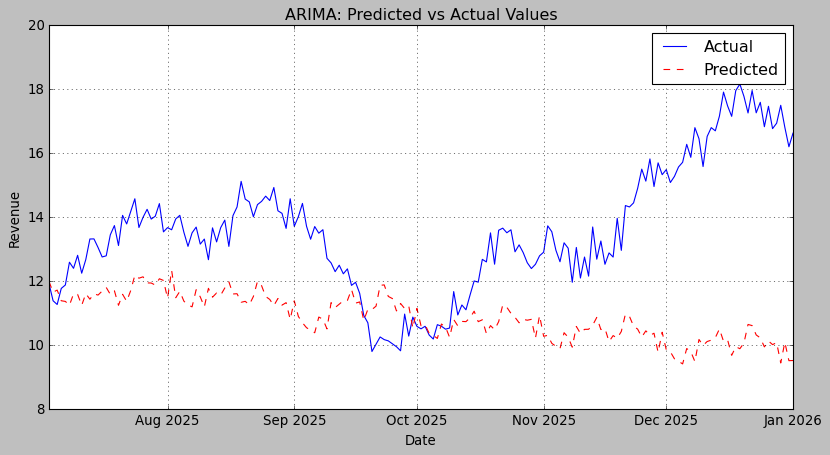

In [216]:
test_predictions = final_model.forecast(steps=len(test))

# Create a dataframe with actual and predicted values
comparison_df = pd.DataFrame({
    'Actual': test['Revenue'],
    'Predicted': test_predictions
}, index=test.index)

# Calculate error metrics
rmse = np.sqrt(mean_squared_error(comparison_df['Actual'], comparison_df['Predicted']))
mape = mean_absolute_percentage_error(comparison_df['Actual'], comparison_df['Predicted']) * 100

# Plot the comparison
plt.figure(figsize=(12, 6))
plt.plot(comparison_df.index, comparison_df['Actual'], label='Actual', color='blue')
plt.plot(comparison_df.index, comparison_df['Predicted'], label='Predicted', color='red', linestyle='--')
plt.title('ARIMA: Predicted vs Actual Values')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

# Print metrics
print("\nModel Performance Metrics:")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Print first few comparisons
print("\nFirst few predictions vs actuals:")
print(comparison_df.head())